In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

import matplotlib.patches as mpatches
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### prepping for mapping

In [2]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)


#### getting list of different metros zips to split model if necessary 

In [3]:
# lists of relevent zipcodes
target_zips = pd.read_csv('target.csv', index_col = 0)
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())
# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}


#### Loading and processing data to put into model

In [4]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )
#'new_feature'
# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa',#'new_feature'
       ],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', #'new_feature'
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)


#### Adding net approve feature.

In [5]:
merged_df['tx_net_approve_12_month_shift'] = (merged_df['tx_is_better_12_month_shift'] - 
                                              merged_df['tx_is_worse_12_month_shift'])


#### Features to put into model. Splitting test, train, forecast

In [6]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',    
    'tx_net_approve_12_month_shift'
    
]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
# test will have all zips. 
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test all
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)


#### Construct model

In [7]:
lasso = Lasso(max_iter = 50000, random_state = 33)
alphas = [0.1,0.2,0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=5,n_jobs = -1, verbose=3,
                  scoring = 'neg_root_mean_squared_error')
# training on all non Houston zipcodes
clf.fit(X, y)

print(f"Best alpha {clf.best_params_['alpha']}")

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


#### Creating Coefficients of Model

In [8]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
unselected_coef_df = coef_df[coef_df['coefs']==0]
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,237.244856,237.244856
1,zori_ssa_1_diff_lag_12,26.304015,26.304015
2,zori_ssa_6_diff_lag_12,-16.864855,16.864855
3,zori_ssa_12_diff_lag_12_per,4.323890,4.323890
4,total_sales_tax_12_month_shift,-4.170712,4.170712
5,housing_units_over_50_units_36_month_shift,-3.671122,3.671122
6,housing_units_built_1960_to_1969_36_month_shift,3.401850,3.401850
7,children_annual_pct_change_48_month_shift,-2.595727,2.595727
8,black_pop_48_month_shift,2.446128,2.446128
9,housing_units_single_family_attached_owned_36_...,-2.011038,2.011038


####  testing all zipcodes on the model

In [9]:
y_pred_test = clf.predict(X_test)

test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

rms = mean_squared_error(y_test, y_pred_test, squared=False)
rms


53.56478327318194

In [10]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_test)

0.9553451892401778

####  Feeding forecast values into model

In [11]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore


#### Construct timeline of zori and what prediciton status they are.

In [12]:
# put actual data into correct format
zori_pred_act = zri[['Time','zip_code','zori_ssa']].dropna(subset=['zori_ssa'])
zori_pred_act['model_code'] = 'actual_values'
# put train into correct format
zori_pred_train = test[['Time','zip_code','pred']]
zori_pred_train.columns = ['Time','zip_code','zori_ssa']
zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
# put forecast into correct format
zori_pred_fore = forecast[['Time','zip_code','pred']]
zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
zori_pred_fore['model_code'] = 'lasso_base'
# concat them together
zori_pred = pd.concat([zori_pred_act, zori_pred_train, 
                       zori_pred_fore]).reset_index(drop=True)

zori_pred.to_csv('zori_pred_lasso_base.csv')

<ipython-input-12-9d07dc34fbe8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
<ipython-input-12-9d07dc34fbe8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_fore['model_code'] = 'lasso_base'


In [14]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']

pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_act_growth=('actual_12_month_growth_per', 'mean'),
    std_act_growth=('actual_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

five_per_zips = pred_growth[((pred_growth['mean_pred_growth']>.04) &
                             (pred_growth['std_pred_growth']<1))
                           ].zip_code.to_list()
naive_five_per_zips = pred_growth[((pred_growth['mean_naive_growth']>.04) &
                             (pred_growth['std_naive_growth']<1))
                           ].zip_code.to_list()

In [15]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


pred_growth.loc[:,'invest_rec_5_per'] = 0
pred_growth.loc[pred_growth['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
pred_growth.loc[pred_growth['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
pred_growth.loc[(pred_growth['zip_code'].isin(naive_five_per_zips) &
          pred_growth['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2

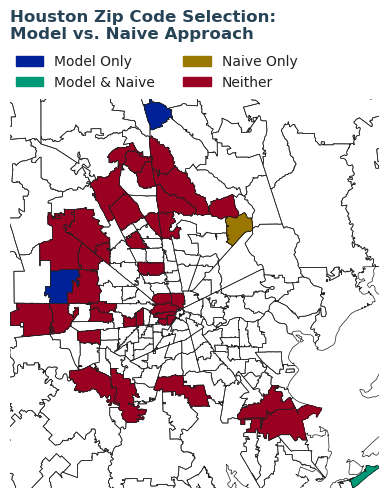

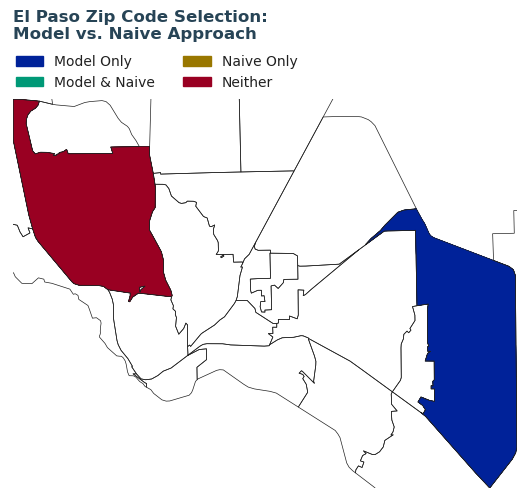

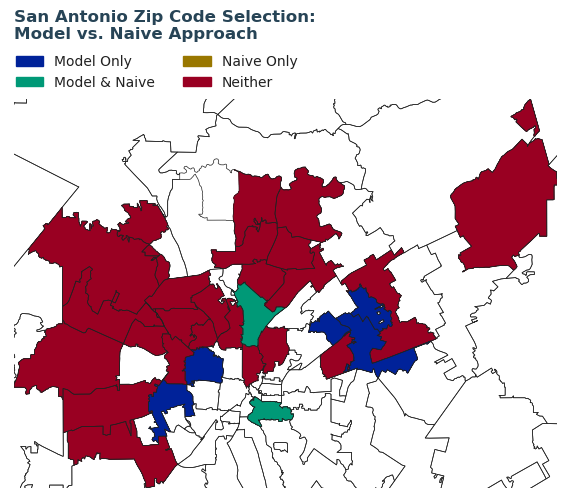

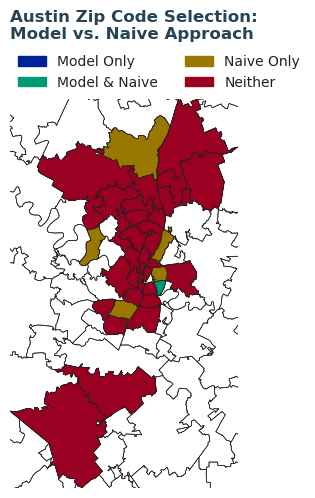

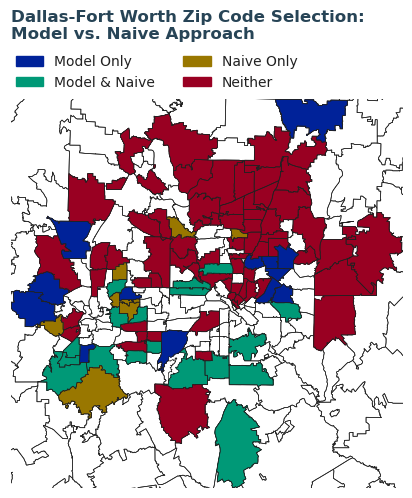

In [16]:
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    acutal_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    lasso_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    rf_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    xg_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

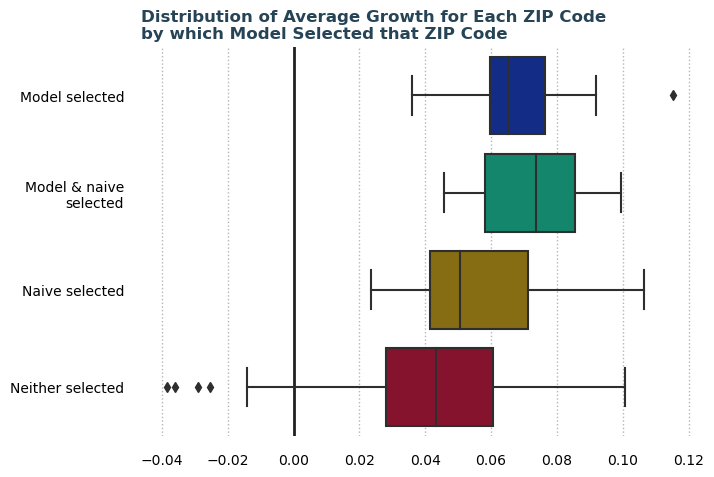

In [18]:
graph_df = pred_growth
blacks = ['#212121']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'invest_rec_5_per',
                x = 'mean_act_growth', palette = four_colors[::-1],
                orient = 'h',ax = ax, order = [3,2,1,0]
                )

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
# plt.yticks(fontweight='bold')

# # set labels
g.set_yticklabels(labels = [
    'Model selected', 'Model & naive\nselected', 
    'Naive selected', 'Neither selected'
])
# g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])




# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Average Growth for Each ZIP Code'+
      ' \nby which Model Selected that ZIP Code')

# # adding a vertical line at 0 percent growth
# blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

# g.set_xticklabels(labels = ['','-4%','-2%','0%','2%','4%','6%',
#                             '8%','10%','12%'
#                            ])
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

plt.show()

#### forecasted recommendations

In [22]:
forecast['pred_12_month_growth'] = forecast['pred'] - forecast['zori_ssa_12_month_shift']
forecast['pred_12_month_growth_per'] = forecast['pred_12_month_growth']/forecast['zori_ssa_12_month_shift']

fore_pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

fore_five_per_zips = fore_pred_growth[((fore_pred_growth['mean_pred_growth']>.04) &
                             (fore_pred_growth['std_pred_growth']<1))
                           ].zip_code.to_list()
fore_naive_five_per_zips = fore_pred_growth[((fore_pred_growth['mean_naive_growth']>.04) &
                             (fore_pred_growth['std_naive_growth']<1))
                           ].zip_code.to_list()

In [23]:
forecast.loc[:,'invest_rec_5_per'] = 0
forecast.loc[forecast['zip_code'].isin(fore_five_per_zips),'invest_rec_5_per'] = 3
forecast.loc[forecast['zip_code'].isin(fore_naive_five_per_zips),'invest_rec_5_per'] = 1
forecast.loc[(forecast['zip_code'].isin(fore_naive_five_per_zips) &
          forecast['zip_code'].isin(fore_five_per_zips))
          ,'invest_rec_5_per'] = 2


fore_pred_growth.loc[:,'invest_rec_5_per'] = 0
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_five_per_zips),'invest_rec_5_per'] = 3
fore_pred_growth.loc[fore_pred_growth['zip_code'].isin(fore_naive_five_per_zips),'invest_rec_5_per'] = 1
fore_pred_growth.loc[(fore_pred_growth['zip_code'].isin(fore_naive_five_per_zips) &
          fore_pred_growth['zip_code'].isin(fore_five_per_zips))
          ,'invest_rec_5_per'] = 2

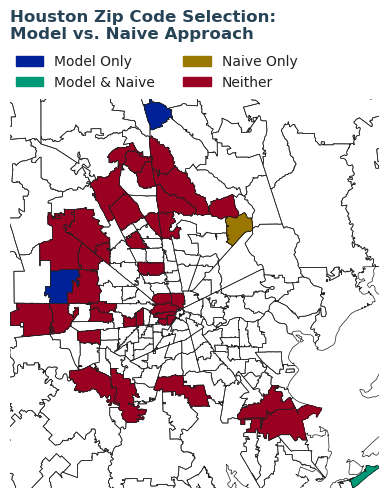

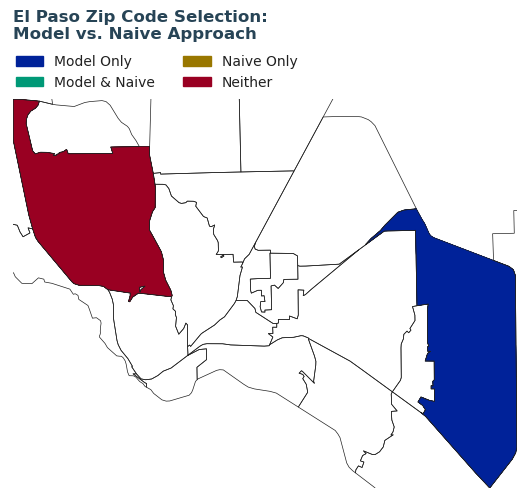

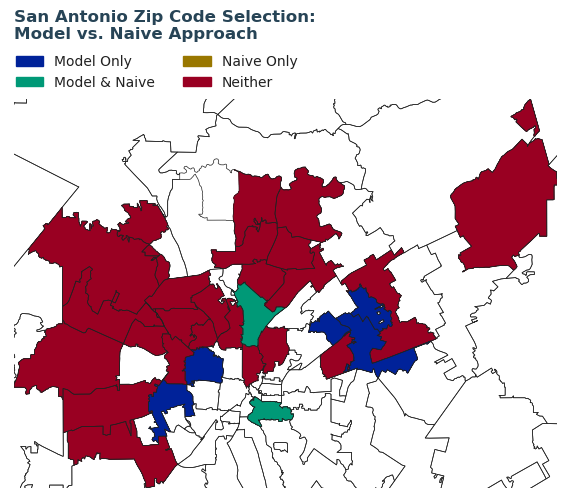

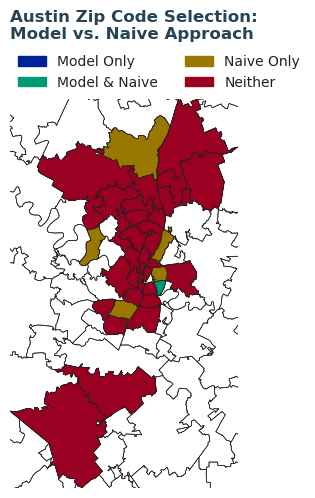

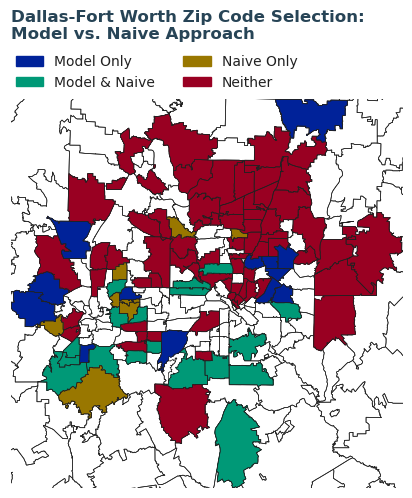

In [24]:
four_colors = ['#990022','#997700','#009977','#002299']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = forecast
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
    # # legend
    acutal_patch = mpatches.Patch(color=four_colors[3], 
                               label='Model Only')
    lasso_patch = mpatches.Patch(color=four_colors[2], 
                               label='Model & Naive')
    rf_patch = mpatches.Patch(color=four_colors[1], 
                               label='Naive Only')
    xg_patch = mpatches.Patch(color=four_colors[0], 
                               label='Neither')
    plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
                    title = '')
    plt.show()

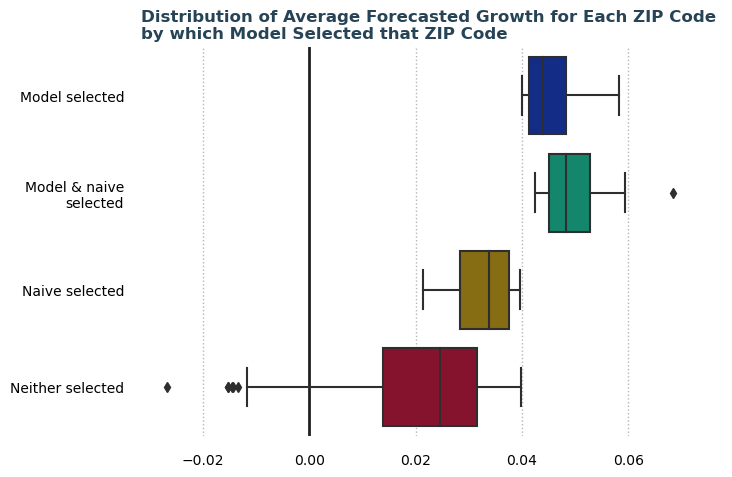

In [27]:
graph_df = fore_pred_growth
blacks = ['#212121']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'invest_rec_5_per',
                x = 'mean_pred_growth', palette = four_colors[::-1],
                orient = 'h',ax = ax, order = [3,2,1,0]
                )

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
# plt.yticks(fontweight='bold')

# # set labels
g.set_yticklabels(labels = [
    'Model selected', 'Model & naive\nselected', 
    'Naive selected', 'Neither selected'
])
# g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])




# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Average Forecasted Growth for Each ZIP Code'+
      ' \nby which Model Selected that ZIP Code')

# # adding a vertical line at 0 percent growth
# blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

# g.set_xticklabels(labels = ['','-4%','-2%','0%','2%','4%','6%',
#                             '8%','10%','12%'
#                            ])
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

plt.show()

In [20]:
pred_errors = test.groupby('zip_code').agg({'pred_difference_per':'mean'}).reset_index()

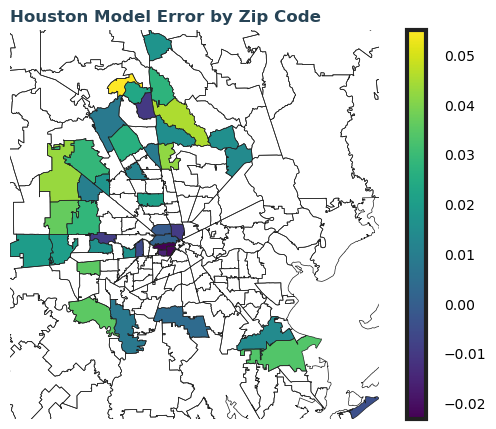

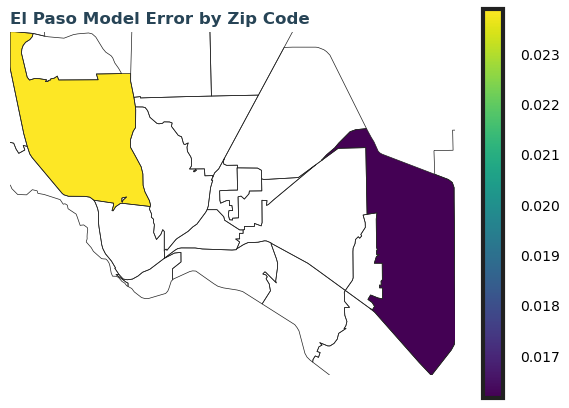

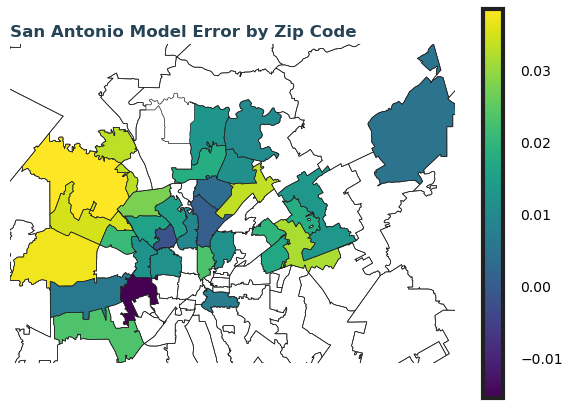

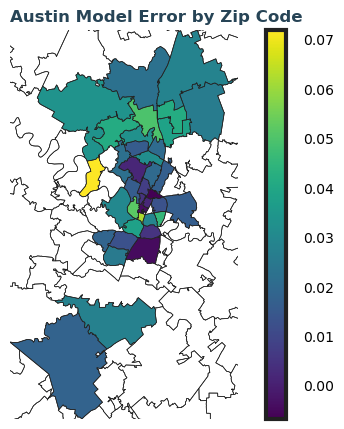

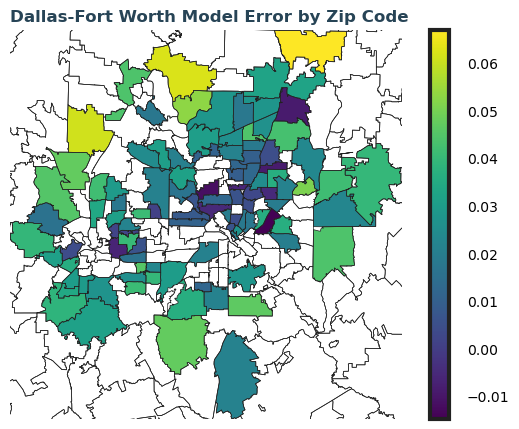

In [21]:
four_colors = ['#990022','#997700','#009977','#002299']
map_ = pred_errors
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Model Error by Zip Code')
    plt.show()


# map_ = test
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():
#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
# #                      column = graph_df["invest_rec_5_per"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro +' Zip Code Selection:\nModel vs. Naive Approach\n\n\n')
#     # # legend
#     acutal_patch = mpatches.Patch(color=four_colors[3], 
#                                label='Model Only')
#     lasso_patch = mpatches.Patch(color=four_colors[2], 
#                                label='Model & Naive')
#     rf_patch = mpatches.Patch(color=four_colors[1], 
#                                label='Naive Only')
#     xg_patch = mpatches.Patch(color=four_colors[0], 
#                                label='Neither')
#     plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
#                loc='center left', 
#                bbox_to_anchor=(-0.02, 1.07),frameon=False,ncol=2,
#                     title = '')
#     plt.show()